# Prompt tuning

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict
import numpy as np

In [3]:
train_df = pd.read_pickle("train_dataset")
test_df = pd.read_pickle("test_dataset")
val_df = pd.read_pickle("val_dataset")

In [4]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df),
    'unsupervised': Dataset.from_pandas(val_df)
})

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 427
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 92
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 92
    })
})

In [6]:
dataset['train'][7]

{'text': 'So regarding part 1 of the question, I think the lady is behind the door!',
 'label': 4}

## Setup

In [7]:
# Install latest bitsandbytes & transformers, accelerate from source
%pip install -q -U bitsandbytes
# %pip install -q -U git+https://github.com/huggingface/transformers.git
# %pip install -q -U git+https://github.com/huggingface/peft.git
# %pip install -q -U git+https://github.com/huggingface/accelerate.git
%pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
# Other requirements for the demo
%pip install gradio
%pip install sentencepiece
%pip install protobuf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Loading the model

In [8]:
# Required for a meta-llama/Llama-2-13b-chat-hf
from dotenv import load_dotenv
import os

load_dotenv()  # This loads the .env file into the environment

hf_token = os.getenv('HF_TOKEN')

In [9]:
import torch
from peft import PeftModel    
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaTokenizer, StoppingCriteria, StoppingCriteriaList, TextIteratorStreamer, DataCollatorWithPadding
from accelerate import Accelerator
import evaluate

os.environ["HUGGINGFACE_TOKEN"] = hf_token

model_name = "meta-llama/Llama-2-13b-chat-hf"

print(f"Starting to load the model {model_name} into memory")

m = AutoModelForCausalLM.from_pretrained(
    model_name,
    #load_in_4bit=True,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    use_auth_token=True
)

print(f"Successfully loaded the model {model_name} into memory")

Starting to load the model meta-llama/Llama-2-13b-chat-hf into memory


/d/hpc/home/bi4528/.venv/lib64/python3.11/site-packages/transformers/models/auto/auto_factory.py:468: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Successfully loaded the model meta-llama/Llama-2-13b-chat-hf into memory


In [10]:
adapters_name = 'timdettmers/guanaco-13b'

m = PeftModel.from_pretrained(m, adapters_name)
m = m.merge_and_unload()
tok = LlamaTokenizer.from_pretrained(model_name, use_auth_token=True)
tok.bos_token_id = 1

stop_token_ids = [0]

tok.pad_token = tok.eos_token
tok.pad_token_id = tok.eos_token_id

m.config.pad_token_id = tok.pad_token_id

accelerator = Accelerator()
m = accelerator.prepare(m)
# print(f"Model and tokenizer are ready and using {accelerator.device}")

/d/hpc/home/bi4528/.venv/lib64/python3.11/site-packages/transformers/tokenization_utils_base.py:1974: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [78]:
def count_tokens(prompt):
    tokens = tok.encode(prompt, add_special_tokens=False)
    return len(tokens)

In [11]:
# torch.cuda.empty_cache()

In [12]:
# import gc 
# gc.collect()

In [87]:
from transformers import StoppingCriteria, StoppingCriteriaList

class CompleteWordCriteria(StoppingCriteria):
    def __init__(self, tokenizer, valid_words):
        self.tokenizer = tokenizer
        self.valid_words = valid_words

    def __call__(self, input_ids, scores):
        # Decode the last generated token to a word
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
        last_word = tokens[-1]
        # Decode the entire sequence to check the last whole word
        decoded_sequence = self.tokenizer.decode(input_ids[0])
        last_generated_word = decoded_sequence.split()[-1]
        # Check if the last whole word generated is a valid category word
        return last_generated_word in self.valid_words


def generate_text(prompt, max_length=4096, max_new_tokens=5):
    # Configure the device for model execution
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    # m.to(device)

    # Encode the input prompt into tensor format
    inputs = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    inputs = {k: v.to(m.device, dtype=torch.long)for k, v in inputs.items()}

    # Ensure inputs are on the correct device and dtype is Long
    input_ids = inputs['input_ids'].to(m.device, dtype=torch.long)
    attention_mask = inputs['attention_mask'].to(m.device, dtype=torch.long)

    # Print statements for debugging
    #print(f"input_ids dtype: {input_ids.dtype}")
    #print(f"attention_mask dtype: {attention_mask.dtype}")

    # Define the stopping criteria
    valid_categories = ["Seminar", "Deliberation", "Social", "UX", "Procedure", "Imaginative", "Other"]
    criteria_list = StoppingCriteriaList([CompleteWordCriteria(tok, valid_categories)])

    # Generate text using the model
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            output_sequences = m.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                # max_length=max_length,
                max_new_tokens=max_new_tokens,
                stopping_criteria=criteria_list
            )

    # Decode the generated ids to text
    text = tok.decode(output_sequences[0], skip_special_tokens=True)
    return text

In [119]:
from collections import defaultdict

labelToCategory = {
    0: 'Deliberation',
    1: 'Imaginative',
    2: 'Other',
    3: 'Procedure',
    4: 'Seminar',
    5: 'Social',
    6: 'UX'
}

labelToCategory = defaultdict(lambda: 'Unknown', labelToCategory)

In [120]:
categoryToLabel = {
    'Deliberation': 0,
    'Imaginative': 1,
    'Other': 2,
    'Procedure': 3,
    'Seminar': 4,
    'Social': 5,
    'UX': 6
}

categoryToLabel = defaultdict(lambda: -1, categoryToLabel)


In [86]:
def predict_category(prompt):
    generated_text = generate_text(prompt, max_new_tokens=5)
    # Extract the predicted category from the generated text
    return generated_text.split()[-1], generated_text

In [18]:
def calculate_accuracy(predicted_labels, actual_labels):
    correct_count = sum(p == a for p, a in zip(predicted_labels, actual_labels))
    accuracy = correct_count / len(actual_labels)
    return accuracy


In [95]:
prompt_intro = (
        "You will be given a social media post which you need to classify into one of the following categories:"
        "Seminar, Deliberation, Social, UX, Procedure, Imaginative, Other.\n"
    )
category_description = (
    "Here is a description of each category, based on which the post is classified:\n\n"
    "Posts discussing the deeper meanings of content, encouraging analysis and interpretation.\n"
    "Category: Seminar\n\n"
    "Posts about making decisions, often involving questions and considerations for future actions.\n"
    "Category: Deliberation\n\n"
    "Posts to establish or maintain relationships, often casual and friendly in nature.\n"
    "Category: Social\n\n"
    "Posts discussing the user experience, including issues and feedback about interfaces and usability.\n"
    "Category: UX\n\n"
    "Posts about accomplishing a task, often with step-by-step instructions or suggestions for organizing activities.\n"
    "Category: Procedure\n\n"
    "Posts about imaginative content, often involving hypothetical scenarios or creative storytelling.\n"
    "Category: Imaginative\n\n"
    "Posts that do not fit into any of the above categories.\n"
    "Category: Other\n\n"
)
category_examples = (
    "Here are examples of posts and their categories:\n"
    "Post: I found myself conflicted for the princess. I always want a happy ending of some kind in the stories I read. However, it seems the princess loses either way in this story. If I were in her place, I would have allowed him to marry the woman rather than have him die a painful and bloody death.\n"
    "Category: Imaginative\n\n"
    "Post: I know I wouldn't be able to live with myself if I knew I was the reason the person I loved was killed in such a painful manner\n"
    "Category: Imaginative\n\n"
    "Post: Do you think that the king would be tempted to do the same thing she did, though, and find out which door was which?\n"
    "Category: Imaginative\n\n"
    "Post: I think if I misled him to choose the tiger's door, I would feel like I committed a murder myself\n"
    "Category: Imaginative\n\n"
    "Post: There are other guys out there so even if he was the most handsome and all that,\n"
    "Category: Imaginative\n\n"
    "Post: What would you do in her place?\n"
    "Category: Imaginative\n\n"
    "Post: I agree with that so much!\n"
    "Category: Imaginative\n\n"
    "Post: Unfortunately I can't click in the box below at all, so it's anyone's guess what style our response is supposed to be in. I would imagine answering the questions simply would be fine.\n"
    "Category: UX\n\n"
    "Post: Perhaps the top of this page (where we type and send messages) is for planning and the bottom (open white area) is for writing an end to the story?\n"
    "Category: UX\n\n"
    "Post: it says Alexandrea, Matthew and Sara looked at this 18 days ago. How is this possible? I thought the activity just opened up this week?\n"
    "Category: UX\n\n"
    "Post: Ok it's finally working. I'll read the next part quickly and then I'll be good to keep going. Sorry guys, thanks for your help\n"
    "Category: UX\n\n"
    "Post: im just back at the screen we were at before\n"
    "Category: UX\n\n"
    "Post: Oh good! I can, in fact, click in the box.\n"
    "Category: UX\n\n"
    "Post: I was looking for that\n"
    "Category: UX\n\n"
    "Post: then click submit\n"
    "Category: UX\n\n"
    "Post: Dr. Austin said have fun with it, and it is fun to ponder what might happen in the story. I think the main reason for setting a time to discuss it at the same time would be to test the collaborative software, using the box below instead of this one. I believe we could all write in it at the same time and see each other typing and change each other's words until we all agree we are done with our assessment. If we are able to do that, we might find there are unexpected positives or negatives to the collaboration process or system that we can only otherwise surmise. As you say, we've all responded to the prompts, so what we say doesn't matter that much, so all we'd need is a few minutes to see how using the box works. So if you want to try meeting, I could do Wednesday any time of day. Just set a time and I'll log on then. Thanks.\n"
    "Category: Procedure\n\n"
    "Post: We can continue to discuss individually, or if you want to try writing collaboratively at the same time, please suggest a time. I'm available any evening this week starting at 6 p.m. I'll keep tabs on here from now on to see if you want to do that. Thanks, Robyn\n"
    "Category: Procedure\n\n"
    "Post: Can we plan on Tuesday the 23rd at 8pm to all meet back here to discuss and answer? Thanks\n"
    "Category: Procedure\n\n"
    "Post: I guess that was all we had to do? I don't know if there's anything else to discuss\n"
    "Category: Procedure\n\n"
    "Post: Also, I got an email letting us know that Elias Royal is also a part of our group.\n"
    "Category: Procedure\n\n"
    "Post: SUBMITTED\n"
    "Category: Procedure\n\n"
    "Post: I could write the first draft based on my interpretation of our answers, then we could take turns editing - round robin style until we are happy with the result\n"
    "Category: Deliberation\n\n"
    "Post: Is the response we write in the field below supposed to be in the same style of the story, like we're completing it? Or are we just answering the questions?\n"
    "Category: Deliberation\n\n"
    "Post: Good question Julie, we were discussing before you logged on, we are not quite sure if the prompt is looking for just the answers or an ending to be written\n"
    "Category: Deliberation\n\n"
    "Post: I think we are supposed to surmise or predict what we think happens\n"
    "Category: Deliberation\n\n"
    "Post: I say leave it in. It's well-written and adds depth to the answers.\n"
    "Category: Deliberation\n\n"
    "Post: I agree, Linda Long. If you are okay with that, Michelle Rivera?\n"
    "Category: Deliberation\n\n"
    "Post: Curiosity got the best of me, and I googled this book, which I'd never heard of despite it being a well-known allegory. It presents an unsolvable problem, yet we all felt pretty confident taking a stab at answering the prompts. I wonder what we are to make of all of us feeling pretty certain the princess chose the tiger. Is our choice based on the author's characterization of her or our belief that human nature is fundamentally selfish?\n"
    "Category: Seminar\n\n"
    "Post: Part one: I think the lover follows the Princess's instructions and opens the door on the right to the tiger. Based on how the Princess is described as barbaric like her father I think the King sends his daughter into the tribunal as well. He seems set in his ways and seems to value power over logic and how she struggles between the two options of leading him to his death or leading him to a life. Part two: as mentioned earlier\n"
    "Category: Seminar\n\n"
    "Post: Oooo I have another idea! What if the princess sends the man to the tiger and right out tells her father she did it and wants a trial. Then because he loves her he begs her to choose the door with the young man he picks for her, but she chooses the tiger.\n"
    "Category: Seminar\n\n"
    "Post: Hi Kathryn Bell! I am curious to know why you think the lover would not follow the princess's instructions to open the door on the right? While the princess definitely felt untrustworthy to me, I did not get a sense that the lover felt that from her.\n"
    "Category: Seminar\n\n"
    "Post: I have no guess as to which is behind the door. Is it unclear weather or not she is even instructing him to choose the door on the right side. She could have raised her right hand to signal “DON’T go in that door, the tiger is there.”\n"
    "Category: Seminar\n\n"
    "Post: and Meg brought an interesting topic of the difference between how the princess rambles on about him opening the door with the lady but barely mentions him opening the door with the tiger.\n"
    "Category: Seminar\n\n"
    "Post: Maybe not to enough of a degree not to put her to trial...but he does love her, just like to a degree she loved the man\n"
    "Category: Seminar\n\n"
    "Post: In terms of just answering I feel like the tiger was behind the door, and later the King puts the daughter to trial...\n"
    "Category: Seminar\n\n"
    "Post: Basing a decision on her lineage is not exactly a strong source in my opinion.\n"
    "Category: Seminar\n\n"
    "Post: I want to wait to see what they think about how the ending should go as well.\n"
    "Category: Seminar\n\n"
    "Post: Ok, we all thought the tiger!\n"
    "Category: Seminar\n\n"
    "Post: I don't think it is too much.\n"
    "Category: Seminar\n\n"
    "Post: Marry the girl not the man.\n"
    "Category: Seminar\n\n"
    "Post: I apologize again that I couldn't be part of the original discussion. It was clearly productive and I'm disappointed to have missed out on the opportunity.\n"
    "Category: Social\n\n"
    "Post: Thanks for hopping on for a little bit! I hope you both have a great rest of this semester!\n"
    "Category: Social\n\n"
    "Post: Okay, cool! Should we wait a couple of minutes for Rebecca or get started?\n"
    "Category: Social\n\n"
    "Post: Apologies for my slacking with this, I am also finished now.\n"
    "Category: Social\n\n"
    "Post: Good morning. I'm here.\n"
    "Category: Social\n\n"
    "Post: Enjoy the wedding Katie\n"
    "Category: Social\n\n"
    "Post: Awww thank you so much!\n"
    "Category: Social\n\n"
    "Post: Hello! I can!\n"
    "Category: Social\n\n"
    "Post: Sounds good!\n"
    "Category: Social\n\n"
    "Post: No worries!\n"
    "Category: Social\n\n"
)

In [93]:
def create_prompt(test_text, use_category_desc=True, use_category_ex=True):
    prompt_parts = [prompt_intro]
    if use_category_desc:
        prompt_parts.append(category_description)
    if use_category_ex:
        prompt_parts.append(category_examples)
    prompt_parts.append(f'Post: \"{test_text}\"\nCategory:')
    
    prompt = ''.join(prompt_parts)
    return prompt

In [121]:
from tqdm.notebook import tqdm

# Function to get wrong predictions using prompt-tuned LLAMA model
def evaluate_model(df, use_category_desc=True, use_category_ex=True):
    wrong_predictions_text = []
    wrong_predictions_true_labels = []
    wrong_predictions_labels = []
    predicted_labels = []
    predicted_categories = []

    total_examples = len(df)
    pbar = tqdm(total=total_examples, desc="Processing examples")

    for index, row in df.iterrows(): 
        prompt = create_prompt(row['text'], use_category_desc, use_category_ex)
        predicted_category, gt = predict_category(prompt)
        predicted_label = categoryToLabel[predicted_category]
        predicted_labels.append(predicted_label)
        predicted_categories.append(predicted_category)
        
        true_label = row['label']
        if predicted_label != true_label:
            wrong_predictions_text.append(row['text'])
            wrong_predictions_true_labels.append(true_label)
            wrong_predictions_labels.append(predicted_label)
        pbar.update(1)
    pbar.close()

    return predicted_labels, predicted_categories, wrong_predictions_text, wrong_predictions_true_labels, wrong_predictions_labels

In [116]:
combined_df = pd.concat([test_df, val_df]).reset_index(drop=True)

In [117]:
combined_df

,text,label
0,I just asked Samantha if this activity is time...,3
1,That's what I thought to or how I interpreted ...,4
2,Hey Ashley Peterson! I also wanted to mention ...,4
3,Yes I found this by luck...LOL!,0
4,"Ana, I agree with you that the king is so adam...",4
...,...,...
179,The Lady was behind the door.,4
180,"Not what do you think she would do, but what w...",1
181,ok,0
182,Live without was the first one I put. Then Tr...,0


In [104]:
actual_labels = combined_df['label'].astype(int).tolist()

In [105]:
# Visualize Errors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(wrong_predictions_true_labels, wrong_predictions_labels):
    # Confusion Matrix
    cm = confusion_matrix(wrong_predictions_true_labels, wrong_predictions_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labelToCategory.values(), yticklabels=labelToCategory.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def print_classification_report(wrong_predictions_true_labels, wrong_predictions_labels):
    print(classification_report(wrong_predictions_true_labels, wrong_predictions_labels, target_names=labelToCategory.values()))

In [106]:
def plot_dist_of_wrong_lengths(wrong_predictions_text, name):
    sns.set_theme()
    lengths = [len(text) for text in wrong_predictions_text]
    sns.histplot(lengths, kde=True, bins=20)
    plt.title("Distribution of lengths of wrong predictions of " + name)

    # Add xticts based on bin width
    bin_width = 80
    plt.xticks(np.arange(0, max(lengths), bin_width))


    plt.xlabel("Length of text")
    plt.ylabel("Frequency")

    # Save plot
    plt.savefig("../images/wrong_predictions_length_distribution"+ name.replace(" ", "_")+ ".pdf")

Few-shot prompting

In [122]:
predicted_labels, predicted_categories, wrong_predictions_text, wrong_predictions_true_labels, wrong_predictions_labels = evaluate_model(combined_df)
accuracy = calculate_accuracy(predicted_labels, actual_labels)
print(f"Few-shot prompting accuracy: {accuracy * 100:.2f}%")

Processing examples:   0%|          | 0/184 [00:00<?, ?it/s]

Few-shot prompting accuracy: 15.22%


In [123]:
few_shot_df = pd.DataFrame()
few_shot_df['predicted'] = predicted_labels
few_shot_df['ground_truth'] = actual_labels
few_shot_df['predicted_text'] = predicted_categories
few_shot_df['ground_truth_text'] = list(map(lambda x: labelToCategory[x], actual_labels))
few_shot_df['text'] = combined_df['text']
few_shot_df

,predicted,ground_truth,predicted_text,ground_truth_text,text
0,6,3,UX,Procedure,I just asked Samantha if this activity is time...
1,6,4,UX,Seminar,That's what I thought to or how I interpreted ...
2,6,4,UX,Seminar,Hey Ashley Peterson! I also wanted to mention ...
3,1,0,Imaginative,Deliberation,Yes I found this by luck...LOL!
4,1,4,Imaginative,Seminar,"Ana, I agree with you that the king is so adam..."
...,...,...,...,...,...
179,1,4,Imaginative,Seminar,The Lady was behind the door.
180,1,1,Imaginative,Imaginative,"Not what do you think she would do, but what w..."
181,5,0,Social,Deliberation,ok
182,2,0,Other,Deliberation,Live without was the first one I put. Then Tr...


In [124]:
few_shot_df

,predicted,ground_truth,predicted_text,ground_truth_text,text
0,6,3,UX,Procedure,I just asked Samantha if this activity is time...
1,6,4,UX,Seminar,That's what I thought to or how I interpreted ...
2,6,4,UX,Seminar,Hey Ashley Peterson! I also wanted to mention ...
3,1,0,Imaginative,Deliberation,Yes I found this by luck...LOL!
4,1,4,Imaginative,Seminar,"Ana, I agree with you that the king is so adam..."
...,...,...,...,...,...
179,1,4,Imaginative,Seminar,The Lady was behind the door.
180,1,1,Imaginative,Imaginative,"Not what do you think she would do, but what w..."
181,5,0,Social,Deliberation,ok
182,2,0,Other,Deliberation,Live without was the first one I put. Then Tr...


In [125]:
few_shot_df.to_pickle('few_shot_df.pkl')
few_shot_df.to_csv('few_shot_df.csv')

In [132]:
from sklearn import metrics
print("Testing ...")

score = metrics.accuracy_score(actual_labels, predicted_labels)
print("Classification accuracy:   %0.3f" % score)

print("Classification report:")
print(metrics.classification_report(actual_labels, predicted_labels, zero_division=1))

# Show confusion matrix
print("Confusion matrix:")
cm = metrics.confusion_matrix(actual_labels, predicted_labels)
print(cm)

Testing ...
Classification accuracy:   0.152
Classification report:
              precision    recall  f1-score   support

           0       0.50      0.05      0.08        22
           1       0.15      0.88      0.25         8
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        10
           4       1.00      0.00      0.00       108
           5       0.55      0.52      0.54        21
           6       0.10      0.64      0.18        14

    accuracy                           0.15       184
   macro avg       0.33      0.30      0.15       184
weighted avg       0.72      0.15      0.10       184

Confusion matrix:
[[ 1  5  3  0  0  1 12]
 [ 0  7  0  0  0  1  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  2  0  0  1  7]
 [ 1 35 11  2  0  3 56]
 [ 0  0  5  1  0 11  4]
 [ 0  1  2  0  0  2  9]]


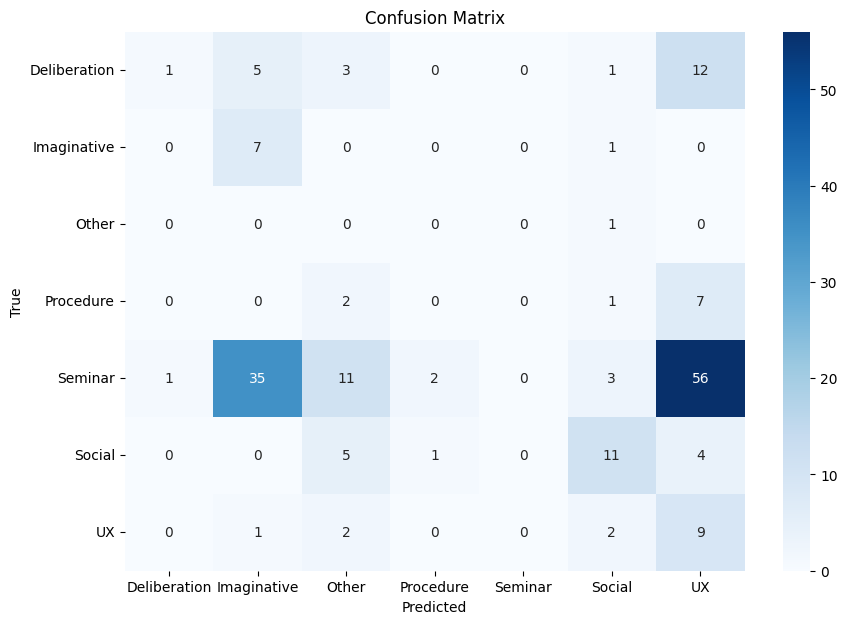

In [133]:
plot_confusion_matrix(actual_labels, predicted_labels)

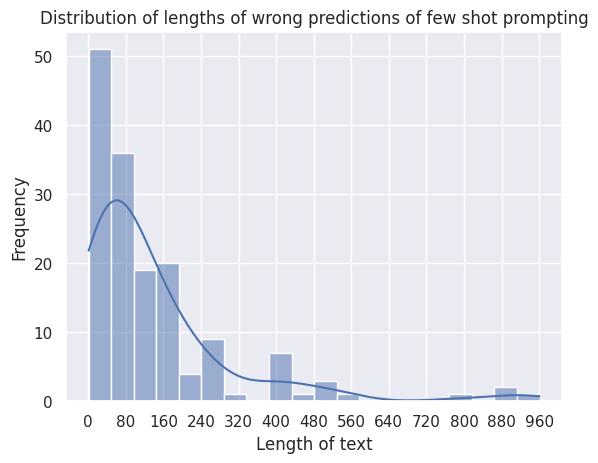

In [134]:
plot_dist_of_wrong_lengths(wrong_predictions_text, 'few shot prompting')

Few-shot without description

In [135]:
predicted_labels, predicted_categories, wrong_predictions_text, wrong_predictions_true_labels, wrong_predictions_labels = evaluate_model(combined_df, use_category_desc=False)
accuracy = calculate_accuracy(predicted_labels, actual_labels)
print(f"Few-shot withour description prompting representatives accuracy: {accuracy * 100:.2f}%")

Processing examples:   0%|          | 0/184 [00:00<?, ?it/s]

Few-shot withour description prompting representatives accuracy: 17.39%


In [136]:
few_shot_no_desc_df = pd.DataFrame()
few_shot_no_desc_df['predicted'] = predicted_labels
few_shot_no_desc_df['ground_truth'] = actual_labels
few_shot_no_desc_df['predicted_text'] = predicted_categories
few_shot_no_desc_df['ground_truth_text'] = list(map(lambda x: labelToCategory[x], actual_labels))
few_shot_no_desc_df['text'] = combined_df['text']
few_shot_no_desc_df

,predicted,ground_truth,predicted_text,ground_truth_text,text
0,6,3,UX,Procedure,I just asked Samantha if this activity is time...
1,5,4,Social,Seminar,That's what I thought to or how I interpreted ...
2,6,4,UX,Seminar,Hey Ashley Peterson! I also wanted to mention ...
3,6,0,UX,Deliberation,Yes I found this by luck...LOL!
4,1,4,Imaginative,Seminar,"Ana, I agree with you that the king is so adam..."
...,...,...,...,...,...
179,1,4,Imaginative,Seminar,The Lady was behind the door.
180,1,1,Imaginative,Imaginative,"Not what do you think she would do, but what w..."
181,5,0,Social,Deliberation,ok
182,6,0,UX,Deliberation,Live without was the first one I put. Then Tr...


In [137]:
few_shot_no_desc_df.to_pickle('few_shot_no_desc_err_df.pkl')
few_shot_no_desc_df.to_csv('few_shot_no_desc_err_df.csv')

In [138]:
score = metrics.accuracy_score(actual_labels, predicted_labels)
print("Classification accuracy:   %0.3f" % score)

print("Classification report:")
print(metrics.classification_report(actual_labels, predicted_labels, zero_division=1))

# Show confusion matrix
print("Confusion matrix:")
cm = metrics.confusion_matrix(actual_labels, predicted_labels)
print(cm)

Classification accuracy:   0.174
Classification report:
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00         0
           0       0.00      0.00      0.00        22
           1       0.16      0.88      0.27         8
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        10
           4       1.00      0.00      0.00       108
           5       0.37      0.76      0.50        21
           6       0.14      0.64      0.23        14

    accuracy                           0.17       184
   macro avg       0.21      0.41      0.12       184
weighted avg       0.65      0.17      0.09       184

Confusion matrix:
[[ 0  0  0  0  0  0  0  0]
 [ 1  0  1  4  0  0  3 13]
 [ 0  0  7  0  0  0  1  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  4  5]
 [ 0  2 35 19  0  0 15 37]
 [ 0  0  0  2  1  0 16  2]
 [ 0  0  1  1  0  0  3  9]]


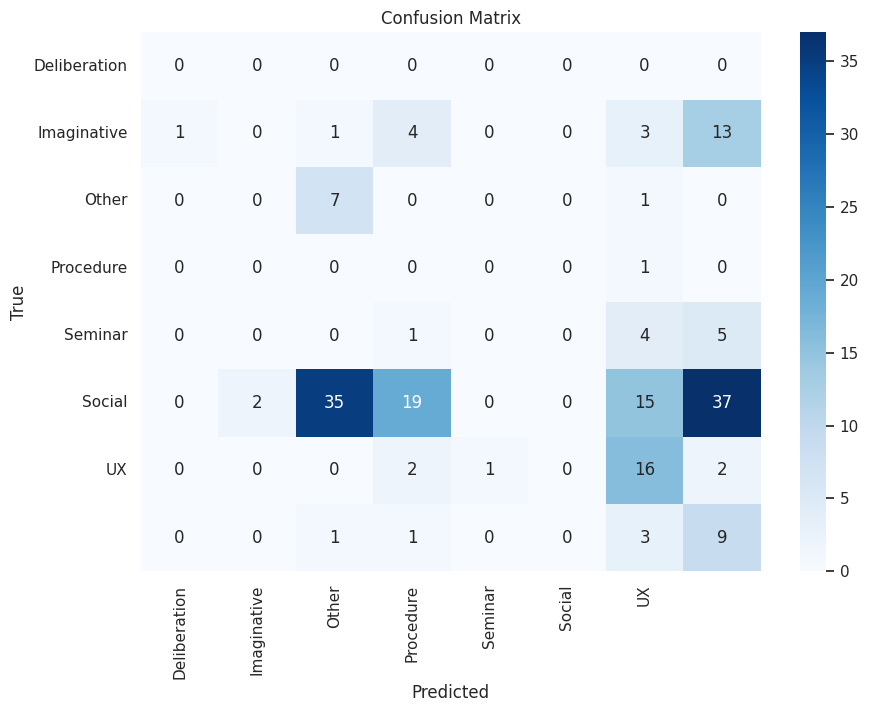

In [139]:
plot_confusion_matrix(actual_labels, predicted_labels)

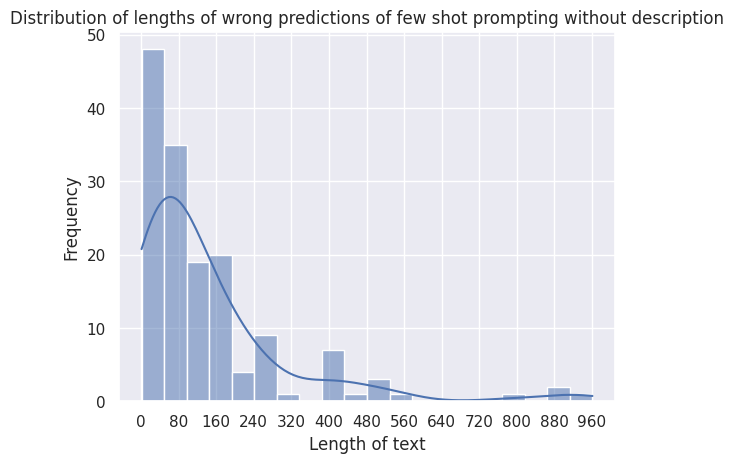

In [140]:
plot_dist_of_wrong_lengths(wrong_predictions_text, 'few shot prompting without description')

Zero-shot

In [141]:
predicted_labels, predicted_categories, wrong_predictions_text, wrong_predictions_true_labels, wrong_predictions_labels = evaluate_model(combined_df, use_category_ex=False)
accuracy = calculate_accuracy(predicted_labels, actual_labels)
print(f"Zero-shot prompting accuracy: {accuracy * 100:.2f}%")

Processing examples:   0%|          | 0/184 [00:00<?, ?it/s]

Zero-shot prompting accuracy: 47.28%


In [142]:
zero_shot_df = pd.DataFrame()
zero_shot_df['predicted'] = predicted_labels
zero_shot_df['ground_truth'] = actual_labels
zero_shot_df['predicted_text'] = predicted_categories
zero_shot_df['ground_truth_text'] = list(map(lambda x: labelToCategory[x], actual_labels))
zero_shot_df['text'] = combined_df['text']
zero_shot_df

,predicted,ground_truth,predicted_text,ground_truth_text,text
0,5,3,Social,Procedure,I just asked Samantha if this activity is time...
1,4,4,Seminar,Seminar,That's what I thought to or how I interpreted ...
2,4,4,Seminar,Seminar,Hey Ashley Peterson! I also wanted to mention ...
3,5,0,Social,Deliberation,Yes I found this by luck...LOL!
4,4,4,Seminar,Seminar,"Ana, I agree with you that the king is so adam..."
...,...,...,...,...,...
179,2,4,Other,Seminar,The Lady was behind the door.
180,0,1,Deliberation,Imaginative,"Not what do you think she would do, but what w..."
181,5,0,Social,Deliberation,ok
182,2,0,Other,Deliberation,Live without was the first one I put. Then Tr...


In [149]:
zero_shot_df

,predicted,ground_truth,predicted_text,ground_truth_text,text
0,5,3,Social,Procedure,I just asked Samantha if this activity is time...
1,4,4,Seminar,Seminar,That's what I thought to or how I interpreted ...
2,4,4,Seminar,Seminar,Hey Ashley Peterson! I also wanted to mention ...
3,5,0,Social,Deliberation,Yes I found this by luck...LOL!
4,4,4,Seminar,Seminar,"Ana, I agree with you that the king is so adam..."
...,...,...,...,...,...
179,2,4,Other,Seminar,The Lady was behind the door.
180,0,1,Deliberation,Imaginative,"Not what do you think she would do, but what w..."
181,5,0,Social,Deliberation,ok
182,2,0,Other,Deliberation,Live without was the first one I put. Then Tr...


In [150]:
zero_shot_df.to_pickle('zero_shot_df.pkl')
zero_shot_df.to_csv('zero_shot_df.csv')

In [152]:
zero_shot_df_errors = pd.DataFrame({
    'text': wrong_predictions_text,
    'true_label': list(map(lambda x: labelToCategory[x], wrong_predictions_true_labels)),
    'predicted_label': list(map(lambda x: labelToCategory[x], wrong_predictions_labels))
})


In [153]:
zero_shot_df_errors.to_pickle('zero_shot_df_errors.pkl')
zero_shot_df_errors.to_csv('zero_shot_df_errors.csv')

In [146]:
score = metrics.accuracy_score(actual_labels, predicted_labels)
print("Classification accuracy:   %0.3f" % score)

print("Classification report:")
print(metrics.classification_report(actual_labels, predicted_labels, zero_division=1))

# Show confusion matrix
print("Confusion matrix:")
cm = metrics.confusion_matrix(actual_labels, predicted_labels)
print(cm)

Classification accuracy:   0.473
Classification report:
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00         0
           0       0.20      0.23      0.21        22
           1       0.00      0.00      0.00         8
           2       0.05      1.00      0.09         1
           3       1.00      0.00      0.00        10
           4       0.88      0.53      0.66       108
           5       0.35      0.95      0.51        21
           6       1.00      0.29      0.44        14

    accuracy                           0.47       184
   macro avg       0.43      0.50      0.24       184
weighted avg       0.71      0.47      0.51       184

Confusion matrix:
[[ 0  0  0  0  0  0  0  0]
 [ 1  5  0  5  0  3  8  0]
 [ 0  2  0  1  0  3  2  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  2  0  0  0  1  7  0]
 [ 3 15  7 10  0 57 16  0]
 [ 0  0  0  1  0  0 20  0]
 [ 1  1  0  3  0  1  4  4]]


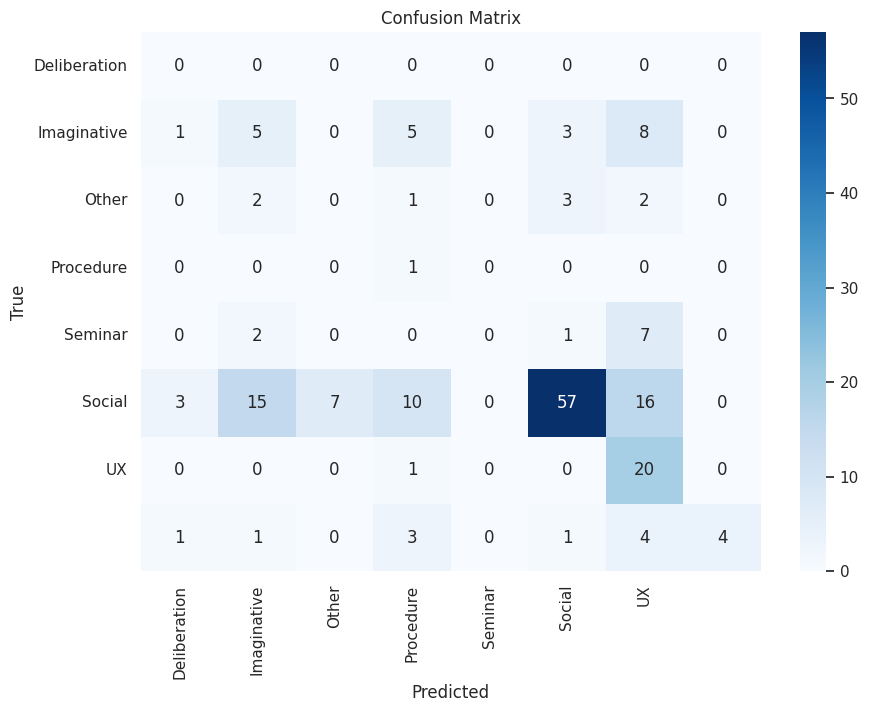

In [147]:
plot_confusion_matrix(actual_labels, predicted_labels)

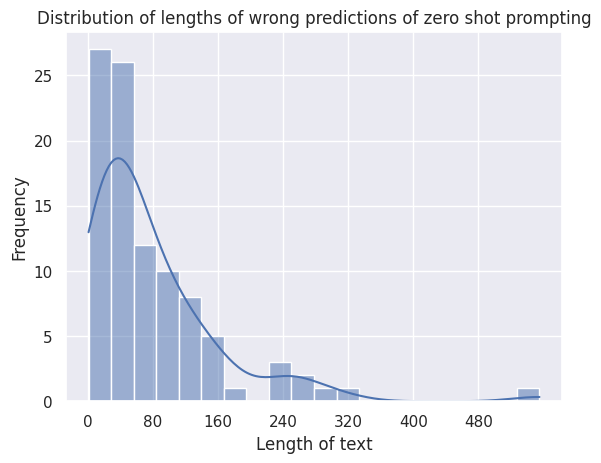

In [148]:
plot_dist_of_wrong_lengths(wrong_predictions_text, 'zero shot prompting')